# Lab 6 - Package Analysis - Security Data Science

Fabian Estuardo Juarez Tello

In [2]:
### Instalación de Scapy (Ejecutar en una celda de Jupyter)
%pip install scapy pandas matplotlib

### Importar librerías necesarias
from scapy.all import *
from scapy.layers.inet import IP, TCP, UDP
import pandas as pd
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Preamble

In [ ]:
### Capturar 25 paquetes de la red doméstica
paquetes = sniff(count=25)
print("Tipo de variable: " + str(type(paquetes)))  # Tipo de la variable
print("Numero de paquetes capturados: " + str(len(paquetes)))   # Longitud
print("Tipo de primer paquete: " + str(type(paquetes[0])))  # Tipo del primer paquete
for i in range(5):
    print("Paquete " + str(i))
    print(paquetes[i].show())  

Tipo de variable: <class 'scapy.plist.PacketList'>
Numero de paquetes capturados: 25
Tipo de primer paquete: <class 'scapy.layers.l2.Ether'>
Paquete 0
###[ Ethernet ]###
  dst       = 33:33:00:00:00:01
  src       = 84:01:12:d1:c6:29
  type      = IPv6
###[ IPv6 ]###
     version   = 6
     tc        = 0
     fl        = 0
     plen      = 120
     nh        = ICMPv6
     hlim      = 255
     src       = fe80::8601:12ff:fed1:c629
     dst       = ff02::1
###[ ICMPv6 Neighbor Discovery - Router Advertisement ]###
        type      = Router Advertisement
        code      = 0
        cksum     = 0xfa72
        chlim     = 64
        M         = 1
        O         = 1
        H         = 0
        prf       = Medium (default)
        P         = 0
        res       = 0
        routerlifetime= 1800
        reachabletime= 0
        retranstimer= 0
###[ ICMPv6 Neighbor Discovery Option - Source Link-Layer Address ]###
           type      = 1
           len       = 1
           lladdr    = 

## Analysis

In [4]:
### Cargar el archivo .pcap
pcap_file = "./analisis_paquetes.pcap"
paquetes_pcap = rdpcap(pcap_file)

### Convertir a DataFrame
data = []
for pkt in paquetes_pcap:
    if IP in pkt:
            packet_info = {
                'Src Address': pkt[IP].src,
                'Dst Address': pkt[IP].dst,
                'Src Port': pkt[TCP].sport if TCP in pkt else pkt[UDP].sport if UDP in pkt else 'N/A',
                'Dst Port': pkt[TCP].dport if TCP in pkt else pkt[UDP].dport if UDP in pkt else 'N/A',
                'Payload': len(pkt),
                'Time': float(pkt.time)
            }
            data.append(packet_info)

df = pd.DataFrame(data)
df['Time'] = pd.to_datetime(df['Time'], unit='s')
print(df[['Src Address', 'Dst Address', 'Src Port', 'Dst Port']].head())

   Src Address  Dst Address  Src Port  Dst Port
0   10.1.10.53  84.54.22.33        53        53
1  84.54.22.33   10.1.10.53        53        53
2   10.1.10.53  84.54.22.33        53        53
3  84.54.22.33   10.1.10.53        53        53
4   10.1.10.53  84.54.22.33        53        53


## Statistics

In [5]:
print("IPs origen únicas:", df["Src Address"].unique())
print("IPs destino únicas:", df["Dst Address"].unique())

ip_frecuente = df["Src Address"].value_counts().idxmax()
print("IP origen más frecuente:", ip_frecuente)

ip_destino_frecuente = df[df["Src Address"] == ip_frecuente]["Dst Address"].value_counts().idxmax()
print("IP destino más frecuente para esta IP:", ip_destino_frecuente)

puerto_destino = df[df["Src Address"] == ip_frecuente]["Dst Port"].value_counts().idxmax()
print("Puerto destino más frecuente:", puerto_destino)

puertos_origen = df[df["Src Address"] == ip_frecuente]["Src Port"].unique()
print("Puertos origen utilizados:", puertos_origen)

IPs origen únicas: ['10.1.10.53' '84.54.22.33' '75.75.75.75']
IPs destino únicas: ['84.54.22.33' '10.1.10.53' '75.75.75.75']
IP origen más frecuente: 10.1.10.53
IP destino más frecuente para esta IP: 84.54.22.33
Puerto destino más frecuente: 53
Puertos origen utilizados: [   53 15812 23903]


## Graficas

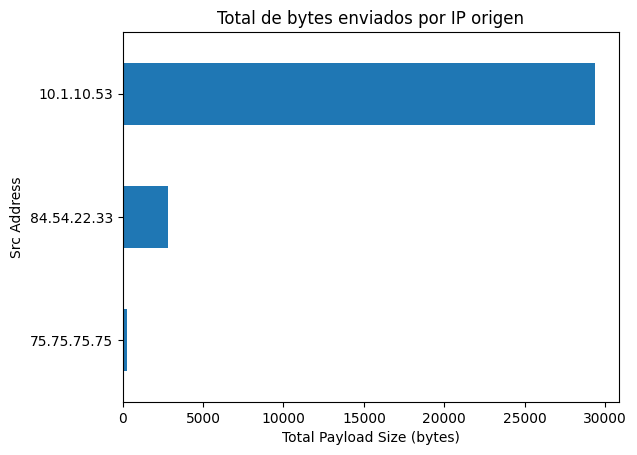

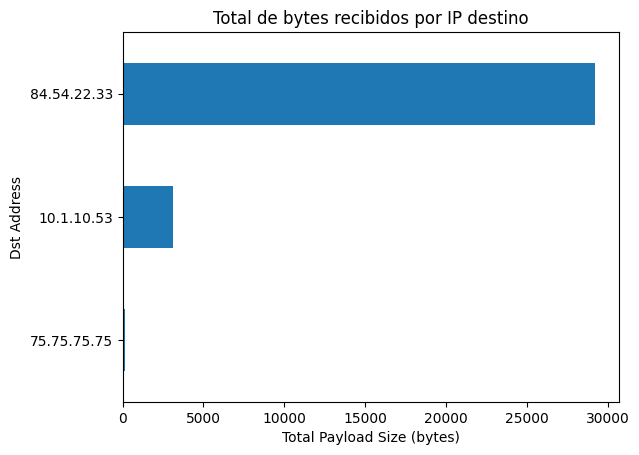

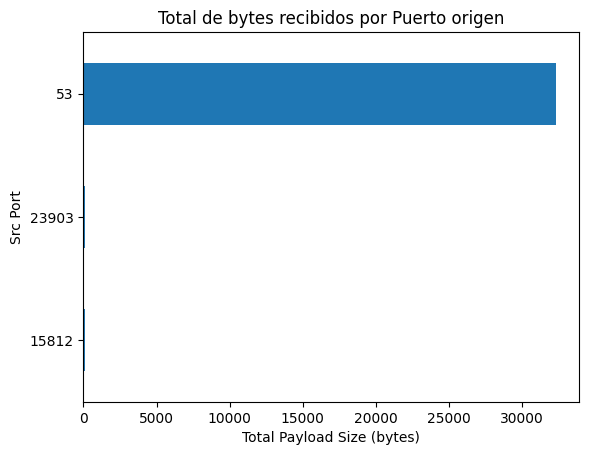

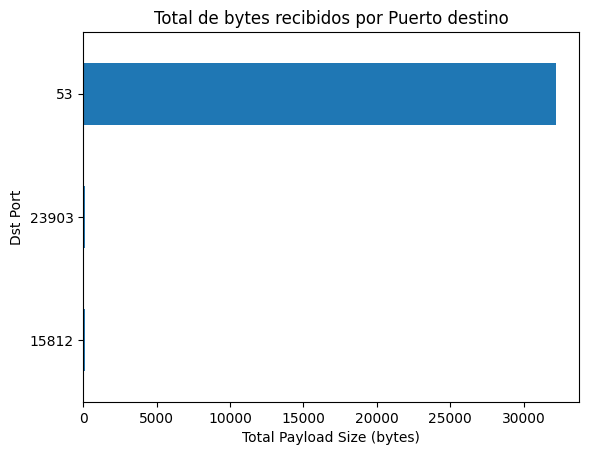

In [6]:
### Gráficas
df.groupby("Src Address")["Payload"].sum().sort_values().plot(kind="barh", title="Total de bytes enviados por IP origen")
plt.xlabel('Total Payload Size (bytes)')
plt.show()

df.groupby("Dst Address")["Payload"].sum().sort_values().plot(kind="barh", title="Total de bytes recibidos por IP destino")
plt.xlabel('Total Payload Size (bytes)')
plt.show()

df.groupby("Src Port")["Payload"].sum().sort_values().plot(kind="barh", title="Total de bytes recibidos por Puerto origen")
plt.xlabel('Total Payload Size (bytes)')
plt.show()

df.groupby("Dst Port")["Payload"].sum().sort_values().plot(kind="barh", title="Total de bytes recibidos por Puerto destino")
plt.xlabel('Total Payload Size (bytes)')
plt.show()

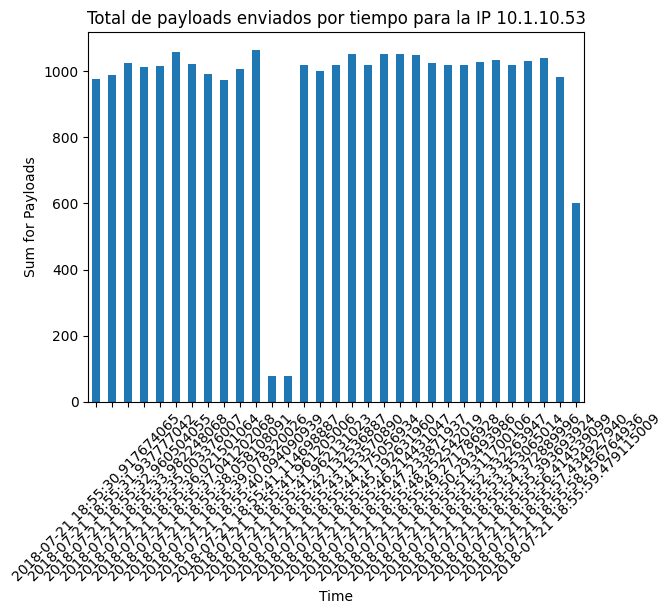

In [7]:
### Gráfica de suma de payloads por tiempo para la IP más frecuente
df_ip_frecuente = df[df["Src Address"] == ip_frecuente].copy()
df_ip_frecuente.set_index("Time", inplace=True)  
df_ip_frecuente["Payload"].plot(kind="bar", title="Total de payloads enviados por tiempo para la IP "+ ip_frecuente)
plt.xlabel("Time")
plt.ylabel("Sum for Payloads")
plt.xticks(rotation=45)
plt.show()


### Results
El comportamiento del tráfico de red depende en gran medida de su contexto y del rol que desempeñan los dispositivos dentro de la infraestructura. En este caso, la IP origen más activa es 10.1.10.53, una dirección local que corresponde a un servidor DNS. Esto explica por qué el puerto 53 es el que concentra la mayor parte del tráfico, ya que este puerto es utilizado por el protocolo DNS para la resolución de nombres de dominio.

Al analizar las gráficas, se puede observar cómo el servidor DNS actúa como intermediario entre los dispositivos de la red local y los servidores externos, gestionando las solicitudes de resolución de nombres y facilitando la comunicación con diversas IPs. Su actividad constante es un comportamiento esperado en redes empresariales o domésticas con alto tráfico, ya que cada solicitud de acceso a sitios web o servicios en línea requiere una consulta DNS previa.

Sin embargo, es importante monitorear si el volumen de tráfico es acorde con el uso normal de la red. En este caso si fue bastante predecible por lo que carece de anomalias significativas. Un tráfico DNS excesivo, especialmente si se observan consultas repetitivas o patrones anómalos, podría indicar actividad sospechosa, como una posible filtración de datos mediante DNS tunneling o la presencia de malware que utiliza el servidor DNS para la comunicación con un servidor de comando y control (C2).

## Payload Analysis

In [8]:
df_sospechoso = df[df["Src Address"] == ip_frecuente]
print("IP sospechosa:", df_sospechoso["Src Address"].unique())

df_sospechoso_grouped = df[df["Src Address"] == ip_frecuente]
print(df_sospechoso_grouped.head())

IP sospechosa: ['10.1.10.53']
  Src Address  Dst Address  Src Port  Dst Port  Payload  \
0  10.1.10.53  84.54.22.33        53        53      975   
2  10.1.10.53  84.54.22.33        53        53      989   
4  10.1.10.53  84.54.22.33        53        53     1026   
6  10.1.10.53  84.54.22.33        53        53     1012   
8  10.1.10.53  84.54.22.33        53        53     1017   

                           Time  
0 2018-07-21 18:55:30.917674065  
2 2018-07-21 18:55:31.937777042  
4 2018-07-21 18:55:32.960504055  
6 2018-07-21 18:55:33.982248068  
8 2018-07-21 18:55:35.003376007  


In [9]:
df_sospechoso_grouped = df_sospechoso.groupby(["Src Address", "Dst Address"])["Payload"].sum().reset_index()
print(df_sospechoso_grouped.head())

  Src Address  Dst Address  Payload
0  10.1.10.53  75.75.75.75      158
1  10.1.10.53  84.54.22.33    29197


In [10]:
ip_sospechosa = df_sospechoso_grouped.loc[df_sospechoso_grouped["Payload"].idxmax(), "Dst Address"]
print("IP sospechosa por mayor tráfico de bytes:", ip_sospechosa)

IP sospechosa por mayor tráfico de bytes: 84.54.22.33


In [11]:
df_conversacion = df[(df["Src Address"] == ip_frecuente) & (df["Dst Address"] == ip_sospechosa)]

print("Conversación entre IPs:", df_conversacion)


Conversación entre IPs:    Src Address  Dst Address  Src Port  Dst Port  Payload  \
0   10.1.10.53  84.54.22.33        53        53      975   
2   10.1.10.53  84.54.22.33        53        53      989   
4   10.1.10.53  84.54.22.33        53        53     1026   
6   10.1.10.53  84.54.22.33        53        53     1012   
8   10.1.10.53  84.54.22.33        53        53     1017   
10  10.1.10.53  84.54.22.33        53        53     1059   
12  10.1.10.53  84.54.22.33        53        53     1022   
14  10.1.10.53  84.54.22.33        53        53      993   
16  10.1.10.53  84.54.22.33        53        53      973   
18  10.1.10.53  84.54.22.33        53        53     1006   
20  10.1.10.53  84.54.22.33        53        53     1065   
26  10.1.10.53  84.54.22.33        53        53     1020   
28  10.1.10.53  84.54.22.33        53        53     1000   
30  10.1.10.53  84.54.22.33        53        53     1018   
32  10.1.10.53  84.54.22.33        53        53     1051   
34  10.1.10.53  

In [15]:
payloads = df_conversacion["Payload"].tolist()


print("Payloads sospechosos:", payloads) 

Payloads sospechosos: [975, 989, 1026, 1012, 1017, 1059, 1022, 993, 973, 1006, 1065, 1020, 1000, 1018, 1051, 1018, 1053, 1051, 1049, 1024, 1020, 1020, 1027, 1033, 1019, 1031, 1041, 983, 602]


### Results

Se observa que todas las conexiones utilizan el puerto 53 tanto en el origen como en el destino, lo cual normalmente se asocia con tráfico DNS. Sin embargo, los tamaños de los payloads intercambiados parecen ser considerablemente grandes para consultas DNS regulares. Generalmente, las consultas y respuestas DNS estándar no requieren payloads de cientos o miles de bytes, ya que suelen contener información compacta sobre nombres de dominio y direcciones IP. Los valores de los payloads en la conversación oscilan entre 973 y 1065 bytes, lo cual es significativamente mayor a lo esperado en consultas/respuestas DNS regulares (que suelen ser menores a 512 bytes en UDP y alrededor de 1500 en casos raros con TCP). El uso reiterado del puerto 53 podría indicar un posible uso del protocolo DNS para transferencia de datos encubierta, como DNS tunneling, una técnica usada en ataques para exfiltrar información o para evadir restricciones de firewall.